In [1]:
import pandas as pd


In [2]:
path = "/Users/saaryalov/Downloads/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

full = pd.concat([train,test],axis=0,ignore_index=True)
sub_example = full[["PassengerId","Survived"]]

# Imputing Missing Values

In [3]:
for col in full.select_dtypes("float64").columns:
    if col != "Survived":
        full[col].loc[full[col].isna()] = train[col].mean()
        
for col in full.select_dtypes("O").columns:     
    full[col].loc[full[col].isna()] = "Missing"

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Feature Engineering


In [4]:
full.head(10)

# Manual Features
full["IsLoner"] = ((full["Age"] >= 18) & (full["SibSp"] == 0) & (full["Parch"]==0))*1
full["IsChild"] = (full["Age"] <= 18)*1
full["IsMarriedMan"] = ((full["Sex"] == "male")&(full["SibSp"]>0))*1
full["IsFamilyGuy"] = ((full["Sex"] == "male")&(full["SibSp"]>0)&(full["Parch"]>0))*1



In [5]:
import re

full["Title"] = full["Name"]

for row in range(0,full.shape[0]):
    full["Title"].loc[row] = re.sub('(.*, )|(\\..*)',"",full["Name"].loc[row])
    



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
dist = pd.Series(index=full["Title"].unique())
for each in dist.index:
    dist.loc[each] = sum(full["Title"]==each)

In [7]:
dist

Mr              757.0
Mrs             197.0
Miss            260.0
Master           61.0
Don               1.0
Rev               8.0
Dr                8.0
Mme               1.0
Ms                2.0
Major             2.0
Lady              1.0
Sir               1.0
Mlle              2.0
Col               4.0
Capt              1.0
the Countess      1.0
Jonkheer          1.0
Dona              1.0
dtype: float64

In [8]:
full.Title[(full.Title=="Don") | (full.Title=="Capt") | (full.Title=="Major") | (full.Title=="Col") | (full.Title=="Jonkheer")] = "Mr"
full.Title[(full.Title=="Ms") | (full.Title=="the Countess") | (full.Title=="Lady")] = "Miss"
full.Title[(full.Title=="Mme") | (full.Title=="Mlle") | (full.Title=="Dona")] = "Mrs"
full.Title[(full.Title=="Sir")] = "Mr"

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [9]:
full.Title.loc[(full.Title=="Don") ]

Series([], Name: Title, dtype: object)

In [10]:
sum(full["Title"]=="Don")

0

In [11]:
dist_2 = pd.Series(index=full["Title"].unique())
for each in dist_2.index:
    dist_2.loc[each] = sum(full["Title"]==each)
dist_2

Mr        767.0
Mrs       201.0
Miss      264.0
Master     61.0
Rev         8.0
Dr          8.0
dtype: float64

In [12]:
# Drop some features
full.drop(["Name","Ticket","Cabin",'PassengerId'],axis=1,inplace=True)


In [13]:
full = pd.get_dummies(full)

In [14]:
train_fe = full[~full.Survived.isna()].loc[0:599]
valid_fe = full[~full.Survived.isna()].loc[600:891]
test_fe = full[full.Survived.isna()]

In [15]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
# Create RF Object
clf = RandomForestClassifier()
# Fit model
fitted = clf.fit(train_fe.drop("Survived",axis=1),train_fe["Survived"])
# Predict
pred = fitted.predict(valid_fe.drop("Survived",axis=1))


In [16]:
accuracy_score(valid_fe["Survived"],pred)

0.7972508591065293

In [17]:
train_fe.drop("Survived",axis=1).dtypes

Age                 float64
Fare                float64
Parch                 int64
Pclass                int64
SibSp                 int64
IsLoner               int64
IsChild               int64
IsMarriedMan          int64
IsFamilyGuy           int64
Embarked_C            uint8
Embarked_Missing      uint8
Embarked_Q            uint8
Embarked_S            uint8
Sex_female            uint8
Sex_male              uint8
Title_Dr              uint8
Title_Master          uint8
Title_Miss            uint8
Title_Mr              uint8
Title_Mrs             uint8
Title_Rev             uint8
dtype: object

In [18]:
import shap
shap_values = shap.TreeExplainer(clf).shap_values(train_fe.drop("Survived",axis=1))



lightgbm is installed...but failed to load!


In [19]:
import numpy as np
np.mean(np.abs(shap_values),axis=1)

array([[5.04247258e-02, 7.72649404e-02, 9.27580272e-03, 6.39667515e-02,
        2.25658227e-02, 1.17459064e-02, 9.30312691e-03, 5.69775272e-03,
        5.19329730e-03, 1.80262845e-02, 0.00000000e+00, 1.35377863e-02,
        1.31422475e-02, 7.91166606e-02, 5.98134081e-02, 3.12661811e-04,
        9.67521454e-03, 1.34953558e-02, 8.38163550e-02, 1.07085042e-02,
        1.01823921e-03, 6.01666667e-01],
       [5.04247258e-02, 7.72649404e-02, 9.27580272e-03, 6.39667515e-02,
        2.25658227e-02, 1.17459064e-02, 9.30312691e-03, 5.69775272e-03,
        5.19329730e-03, 1.80262845e-02, 0.00000000e+00, 1.35377863e-02,
        1.31422475e-02, 7.91166606e-02, 5.98134081e-02, 3.12661811e-04,
        9.67521454e-03, 1.34953558e-02, 8.38163550e-02, 1.07085042e-02,
        1.01823921e-03, 3.98333333e-01]])

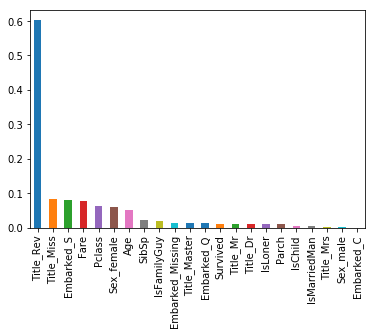

In [20]:
pd.Series(np.mean(np.abs(shap_values),axis=1)[0,:],index=train_fe.columns).sort_values(ascending=False).plot(kind="bar")

In [21]:
# It seems like Title Rev is overfitting
full.columns
full['Title_Mr'] +=  full['Title_Rev']
del full['Title_Rev']

In [22]:
train_fe = full[~full.Survived.isna()].loc[0:599]
valid_fe = full[~full.Survived.isna()].loc[600:891]
test_fe = full[full.Survived.isna()]
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
# Create RF Object
clf = RandomForestClassifier()
# Fit model
fitted = clf.fit(train_fe.drop("Survived",axis=1),train_fe["Survived"])
# Predict
pred = fitted.predict(valid_fe.drop("Survived",axis=1))
accuracy_score(valid_fe["Survived"],pred)

0.8075601374570447

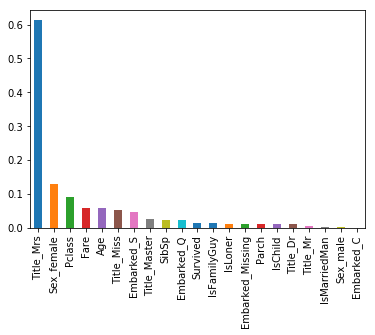

In [23]:
import shap
shap_values = shap.TreeExplainer(clf).shap_values(train_fe.drop("Survived",axis=1))
pd.Series(np.mean(np.abs(shap_values),axis=1)[0,:],index=train_fe.columns).sort_values(ascending=False).plot(kind="bar")

In [24]:
pred = fitted.predict(test_fe.drop("Survived",axis=1))

In [31]:
sub["Survived"]

891     0.0
892     0.0
893     0.0
894     0.0
895     0.0
896     0.0
897     0.0
898     0.0
899     1.0
900     0.0
901     0.0
902     0.0
903     1.0
904     0.0
905     1.0
906     1.0
907     0.0
908     0.0
909     1.0
910     1.0
911     1.0
912     1.0
913     1.0
914     1.0
915     1.0
916     0.0
917     1.0
918     1.0
919     1.0
920     0.0
       ... 
1279    0.0
1280    0.0
1281    0.0
1282    1.0
1283    1.0
1284    0.0
1285    0.0
1286    1.0
1287    0.0
1288    1.0
1289    0.0
1290    0.0
1291    1.0
1292    0.0
1293    1.0
1294    0.0
1295    1.0
1296    0.0
1297    0.0
1298    0.0
1299    1.0
1300    1.0
1301    1.0
1302    1.0
1303    0.0
1304    0.0
1305    1.0
1306    0.0
1307    0.0
1308    1.0
Name: Survived, Length: 418, dtype: float64

In [30]:
pred

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0.

In [37]:
sub = sub_example[sub_example.Survived.isna()]  
sub["Survived"] = pred.astype(int)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
sub.to_csv("anna_titanic_1.csv",index=False)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,